# QN resolved spectra.
Plot the points in the spectrum resolved with some information on their quantum numbers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy


import sys
sys.path.append('../python_data/')
from ed_result_wrapper import EDResult

data_dir = "../python_data/full_production_data/"


def _select_close(cond, df, atol=1e-8):
    """ Selects rows of df if they are close to all conditions in the 
        cond dictionary.
    
        Use with caution!
    
        Note:
         -  The numerical tolerance for closenes is toggled via atol. 
            The standard is 1e-8 (in fact, by numpy) but this could 
            lead to problems when comparing very small numbers.
            
    """
    m = sub.apply(
        lambda r: all([np.all(np.isclose(r[o], v, atol=atol)) for o, v in cond.items()])
    , axis=1)
    return df[m]



def insert_gap(dataframes, winding=True):
    """ Takes a list of dataframes, as obtained from the result wrapper, 
        and returns a dataframe which has information on the corresponding 
        ground state at the given value of lambda.
        
        Adds the following columns:
            - gs_energy
            - gs_winding
            - gap (distance to the ground state at the given lambda)
    
        Notes:
         - This works only if the same values of lambda are present in all datasets.
         - Technically, this could be extended with interpolation, however, I wouldn't to it.
    """
    
    # First, merge all dataframes into a big one.
    # (needs to be a copy for safety)
    alldf = copy(dataframes[0])
    for df in dataframes[1:]:
        alldf = alldf.append(df)
        
    # Find all unique lambdas and make a gs dataframe.
    lams = sorted(list(set(alldf['lambda'])))
    gs = np.zeros(shape=(len(lams),3))
    gs[:,0] = lams
    
    # Loop through all lambdas.
    # For every lambda:
    #  - select appropriate rows
    #  - find the lowest energy value and store as gs_energy
    #  - find the winding of the lowest energy value and store as gs_winding
    for k, lam in enumerate(lams):
        sub = alldf[alldf['lambda']==lam]
        gs[k,1] = np.min(sub['spectrum'])
        if winding:
            gs[k,2] = sub.iloc[sub['spectrum'].argmin()]['winding_sector'][-1]
    
    # Finally make this a DataFrame, needed to efficiently add it to the big DataFrame.
    gsdf = pd.DataFrame(gs, columns=['lambda', 'gs_energy', 'gs_winding'])
    
    # The merge updates all entries that have a specific lambda value with the entries that
    # are in the gsdf for this lambda - this also creates duplicates.
    newdf = pd.merge(gsdf, alldf, on='lambda')
    
    # Now we can easily compute the gap.
    newdf['gap'] = newdf['spectrum'] - newdf['gs_energy']
    return newdf

Generally, reading of the results with the EDResult wrapper can be done on the fly. However, the 2x2x2 data was obtained with full diagonalization which implies many entries to convert -> this adds some overhead time. It's convenient to pre-load them for later use. For the 2x2x4 we still do this on the fly.

*Update: this is only for full diagonalization data, meanwhile we have the sparser data as well - agrees nicely.*

## BOSONS 

### 2x2x2

ED results for datafile '../python_data/full_production_data//results_bosons_wx_2-wy_2-wz_2_2x2x2.hdf5'


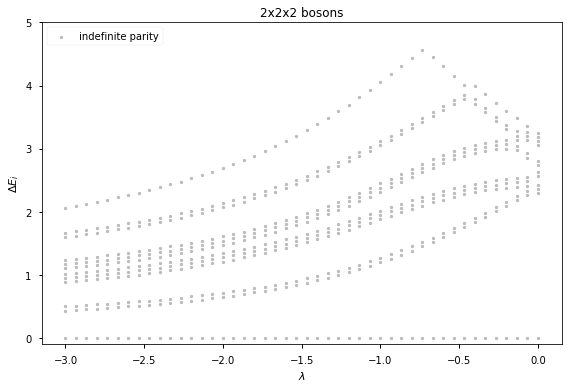

In [9]:
# Choose the dataset.
param = {
    'L' : [2,2,2],
    'gauge_particles' : 'bosons'
}
param.update({'winding_sector': [0,0,0]})
res_000 = EDResult(param, data_dir)


# Select only the lowest states.
n_states = 12

df = insert_gap([res_000.ev])

sub = df[
    (df['N']<n_states) &
    (df['lambda']<=0.0) &
    (df['lambda']>=-3.0)
]

dependency = 'lambda'
observable = 'gap'
with plt.style.context('seaborn-notebook'):
    fig, bx = plt.subplots()
#     fig.set_size_inches(12, 6)
    
    # All points.
    bx.scatter(sub[dependency], sub[observable]+sub['N']/15, marker='.', color='gray', alpha=0.5, zorder=1, s=35, label='indefinite parity')
        
    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(-0.1, 5)

    bx.legend(loc='upper left')
    bx.set_title('{:d}x{:d}x{:d} {:s}'.format(*param['L'], param['gauge_particles']))
    
    
    fig.tight_layout()
    fig.savefig('spectrum_{:s}_{:d}x{:d}x{:d}.pdf'.format(param['gauge_particles'], *param['L']))

### Bosons, 224

ED results for datafile '../python_data/full_production_data//results_bosons_wx_2-wy_2-wz_2_2x2x2.hdf5'
ED results for datafile '../python_data/full_production_data//results_bosons_wx_4-wy_4-wz_2_2x2x4.hdf5'
0      0.000000
1      0.368166
2      0.368166
3      0.680046
4      0.680046
5      0.680046
6      0.703064
7      0.703064
8      0.703064
9      0.999597
10     0.999597
11     1.331853
12    10.647511
13    10.647511
14    10.667948
15    10.771286
16    10.785955
17    10.785955
18    11.123873
19    11.123873
Name: gap, dtype: float64
1500    0.000000
1501    1.134039
1502    1.134039
1503    1.682019
1504    1.682019
1505    1.682019
1506    1.916348
1507    1.916348
1508    1.916348
1509    2.451588
1510    2.451588
1511    3.319164
1512    4.538321
1513    4.538321
1514    4.668416
1515    4.668416
1516    4.668416
1517    4.668416
1518    4.668416
1519    4.668416
Name: gap, dtype: float64
0     0.000000
1     0.013291
2     0.025333
3     0.036936
4     0.036936
5    

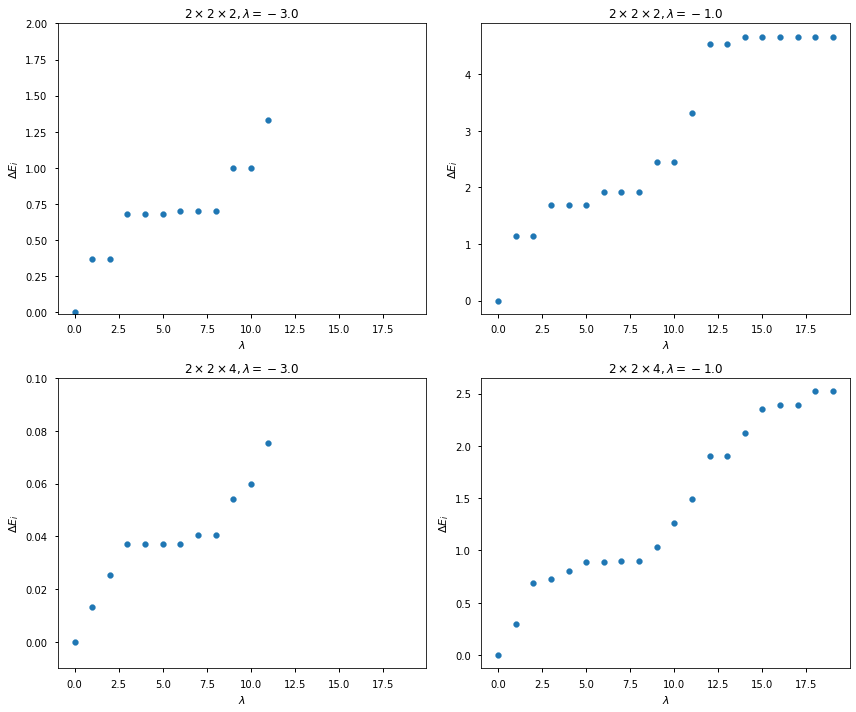

In [42]:
res_222 = EDResult({'L' : [2,2,2], 'gauge_particles' : 'bosons', 'winding_sector': [0,0,0]}, data_dir)
res_224 = EDResult({'L' : [2,2,4], 'gauge_particles' : 'bosons', 'winding_sector': [0,0,0]}, data_dir)

# Select only the lowest states.
n_states = 20

df = {
    (2,2,2) : insert_gap([res_222.ev]),
    (2,2,4) : insert_gap([res_224.ev]),
}

sets = [
    {'L':(2,2,2), 'lambda':-3.0, 'ylim':[-0.01,2]},
    {'L':(2,2,2), 'lambda':-1.0, 'ylim':None},
    {'L':(2,2,4), 'lambda':-3.0, 'ylim':[-0.01,0.1]},
    {'L':(2,2,4), 'lambda':-1.0, 'ylim':None},
]
with plt.style.context('seaborn-notebook'):
    fig, bx = plt.subplots(2,2)
    fig.set_size_inches(12, 10)
    bx = bx.flatten()
    
    # All points.
    for k, p in enumerate(sets):
        ds = df[p['L']]
        sub = ds[
            (ds['N']<n_states) &
            (ds['lambda']==p['lambda'])
        ]
        bx[k].scatter(sub['N'], sub['gap'], marker='o', zorder=1, s=35, label='indefinite parity')
        print(sub['gap'])
        
        bx[k].set_title('${:d}\\times{:d}\\times{:d}, \\lambda={:.1f}$'.format(*p['L'], p['lambda']))

        if p['ylim']:
            bx[k].set_ylim(*p['ylim'])
    # ---
      
    for b in bx:
        b.set_xlabel('$\\lambda$')
        b.set_ylabel('$\\Delta E_i$')
        
    
#     bx.set_ylim(-0.01, 0.1)

#     bx.legend(loc='upper left')
    
    
    fig.tight_layout()
    fig.savefig('degeneracies.png')
#     fig.savefig('spectrum_{:s}_{:d}x{:d}x{:d}.pdf'.format(param['gauge_particles'], *param['L']))

In [ ]:
# Choose the dataset.
param = {
    'L' : [2,2,4],
    'gauge_particles' : 'bosons'
}
param.update({'winding_sector': [0,0,0]})
res_000 = EDResult(param, data_dir)


# Select only the lowest states.
n_states = 50

df = insert_gap([res_000.ev])

sub = df[
    (df['N']<n_states) &
    (df['lambda']<=0.0) &
    (df['lambda']>=-3.0)
]

dependency = 'lambda'
observable = 'gap'
with plt.style.context('seaborn-notebook'):
    fig, bx = plt.subplots()
#     fig.set_size_inches(12, 6)
    
    # All points.
    bx.scatter(sub[dependency], sub[observable], marker='.', color='gray', alpha=0.5, zorder=1, s=35, label='indefinite parity')

    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(-0.1, 0.2)

    bx.legend(loc='upper left')
    bx.set_title('{:d}x{:d}x{:d} {:s}'.format(*param['L'], param['gauge_particles']))
    
    
    fig.tight_layout()
    fig.savefig('spectrum_{:s}_{:d}x{:d}x{:d}.pdf'.format(param['gauge_particles'], *param['L']))